# Hotel Recommendation System

The data is anonymiized and almost all the fields are in numeric formate. the data sets can be found in kaggle, we will be used train.csv 
which captured the loges of user behavior, and destination.csv which contains information related to hotel made by user.

This image provides the schema of train.csv
![title](hotel_data.png)

this images provides the schema of the destination.csv
![title](destination_info.png)

# Load Data and python libraries

In [1]:
#import Analysis libraries
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
#import machine learning libraries
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn import svm

To be able to process locally, we randomly sample 1% of the records. After that, we still have a large number of records.

In [3]:
df = pd.read_csv("Data/train.csv",nrows=200000)
test_df=   pd.read_csv('Data/test.csv',nrows=200000)
dest= pd.read_csv('Data/destinations.csv',nrows=200000)
df.shape

(200000, 24)

# Data Analysis and Visualization

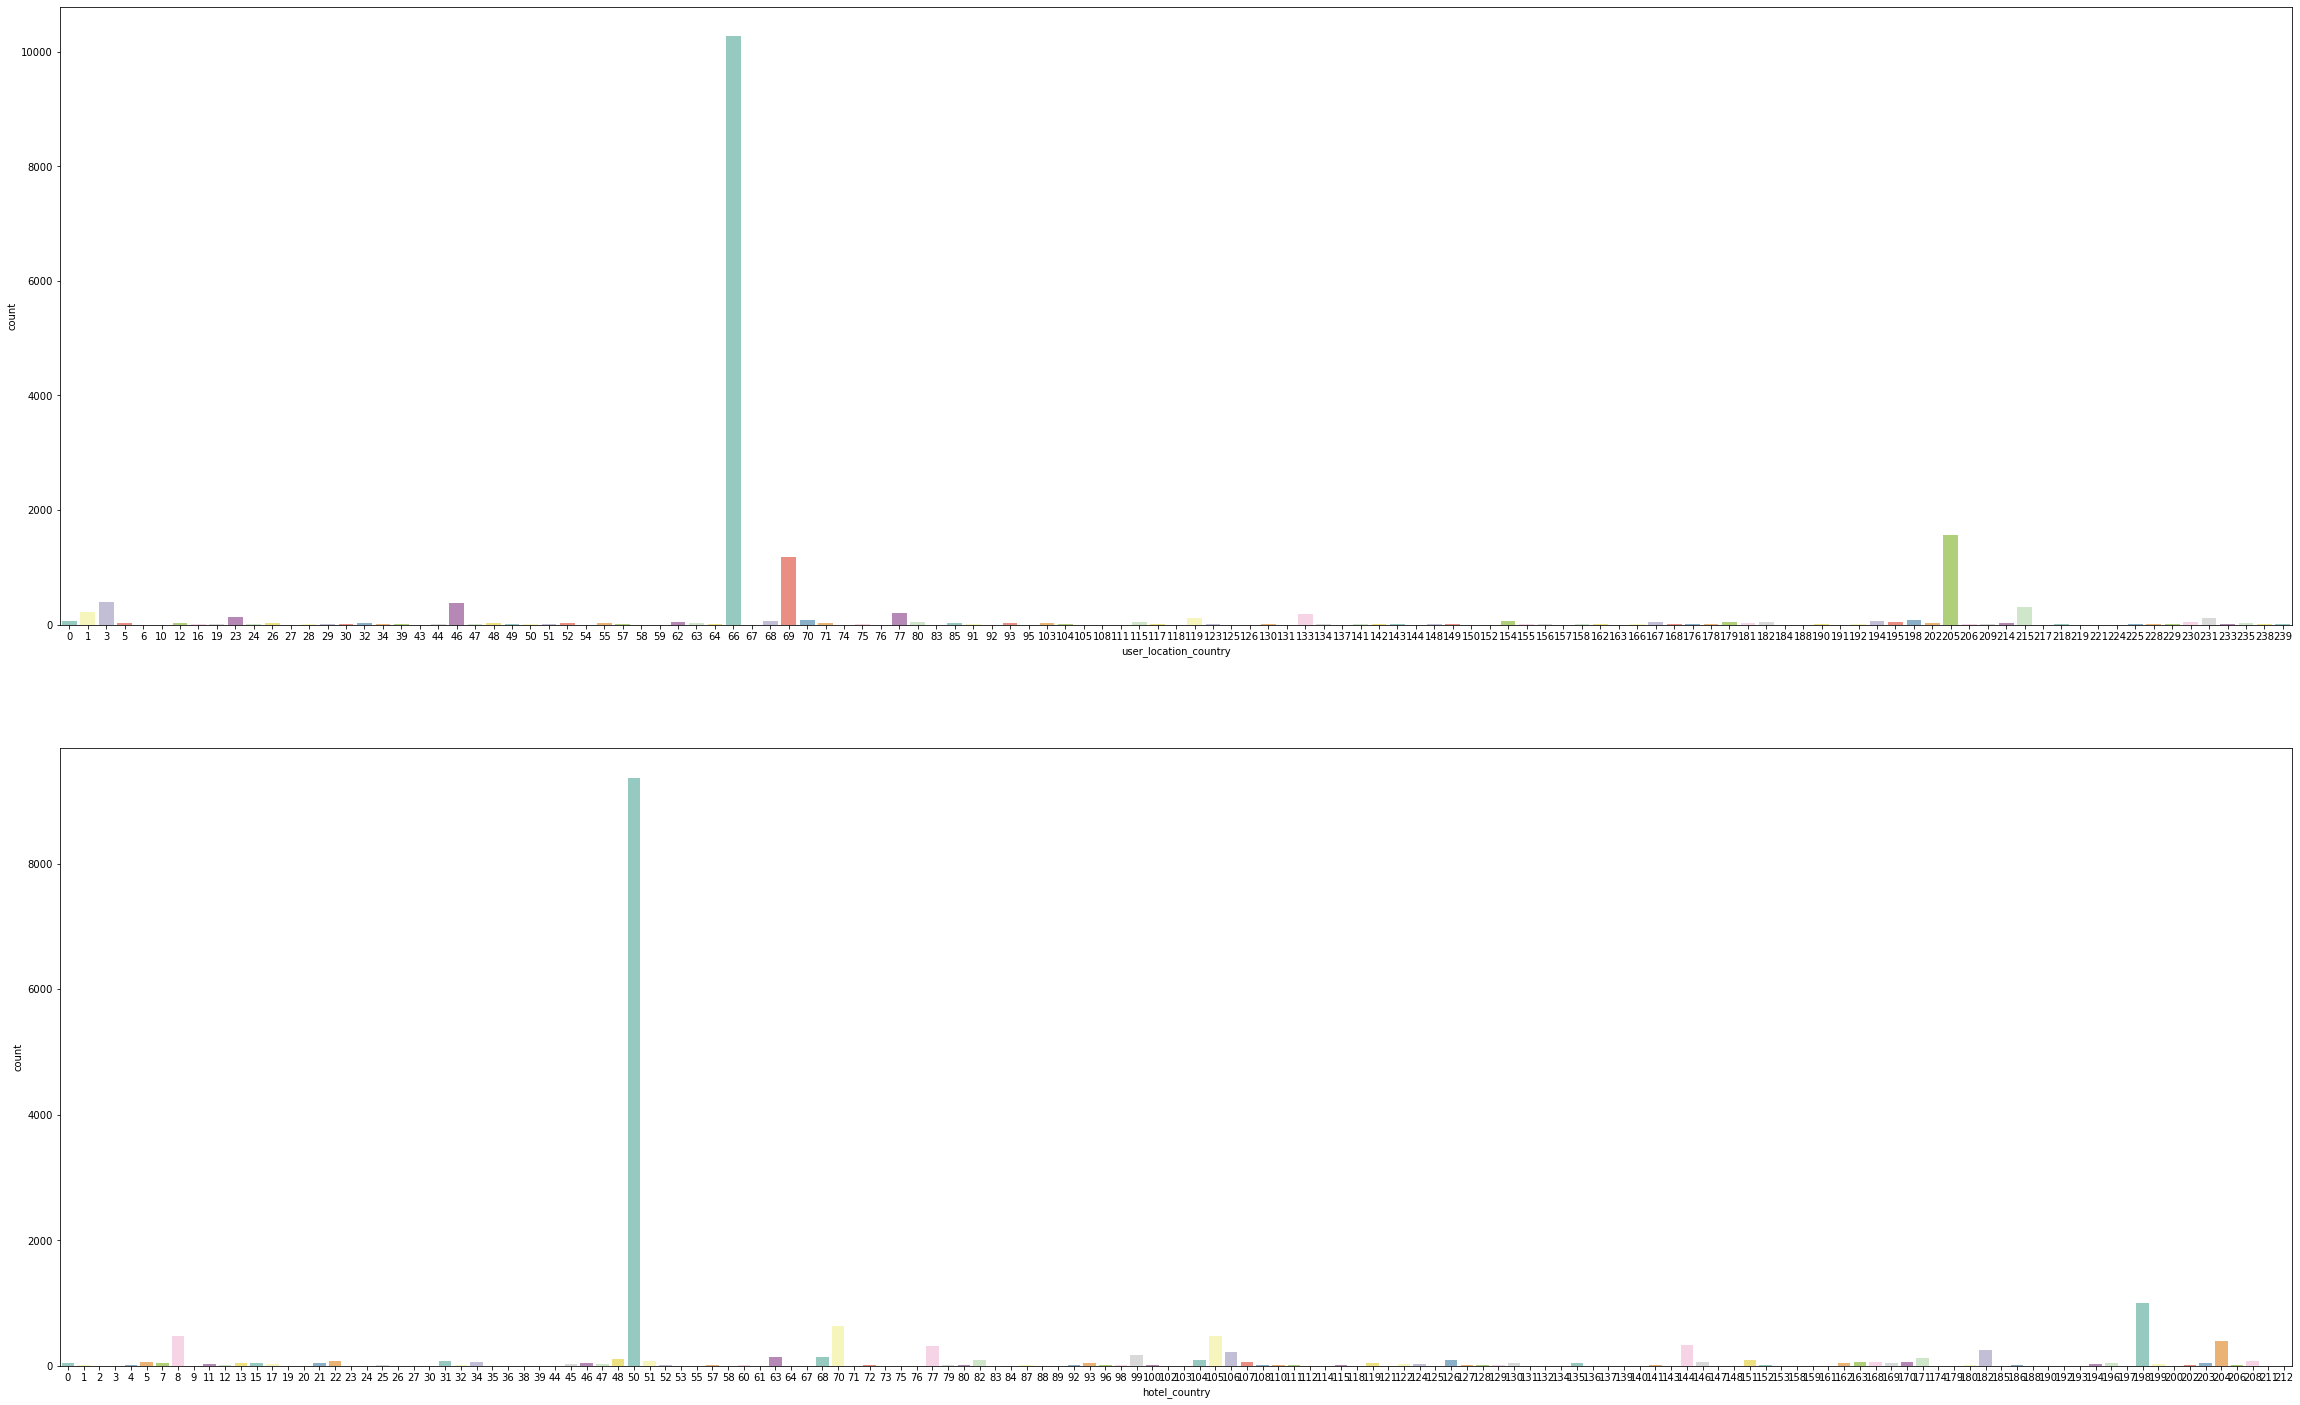

In [4]:
bookings_df = df[df["is_booking"]==1]
fig,(axis1,axis2)= plt.subplots(2,1, figsize=(40,25))
# The Most Countries the customer travel from ?
sns.countplot('user_location_country',data= bookings_df.sort_values(by=['user_location_country']), ax=axis1,palette="Set3")
# The MOst Coutries the custermer travel to ?
sns.countplot('hotel_country',data=bookings_df.sort_values(by=['hotel_country']),ax=axis2,palette="Set3")

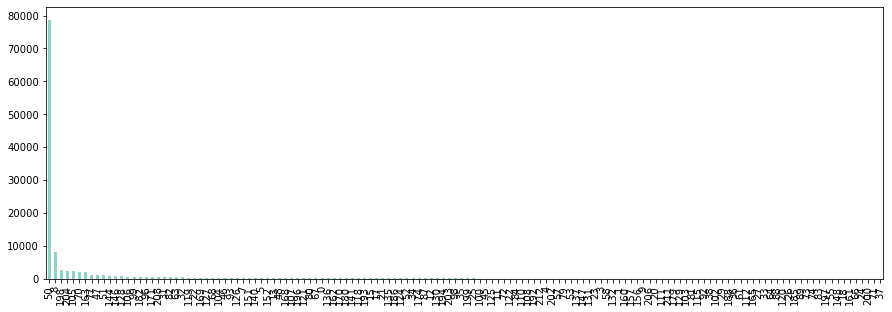

In [5]:
# Where do most of the customers from a country travel?
user_country_id = 66
fig, (axis1) = plt.subplots(1,1,figsize=(15,10))
country_customers = df[df["user_location_country"] == user_country_id]
country_customers["hotel_country"].value_counts().plot(kind='bar',colormap="Set3",figsize=(15,5))

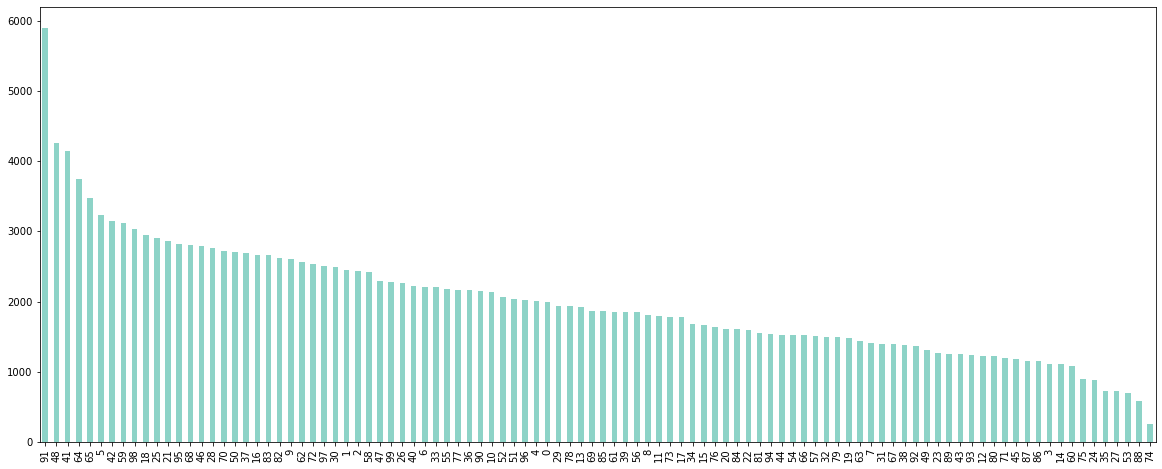

In [6]:
# Plot frequency for each hotel_clusters
df["hotel_cluster"].value_counts().plot(kind='bar',colormap="Set3",figsize=(20,8))

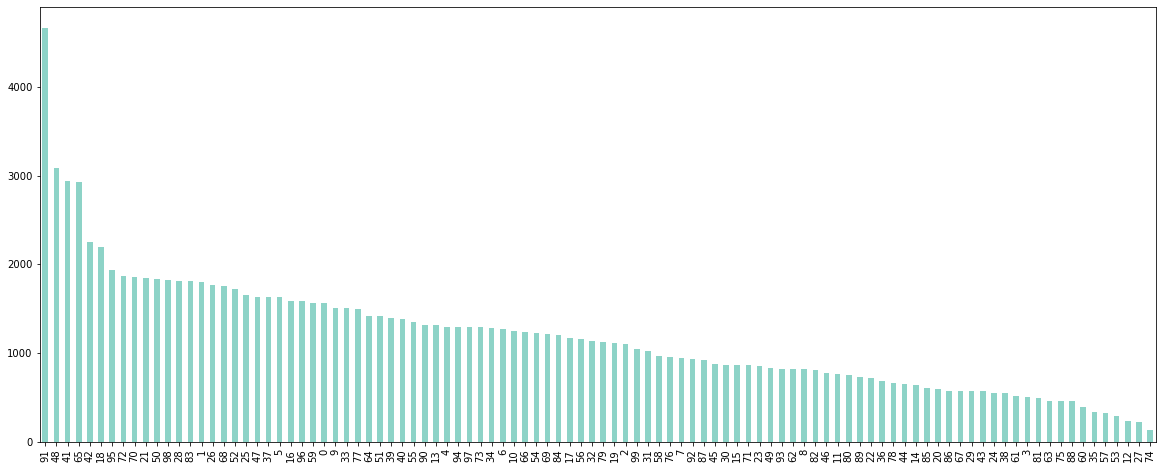

In [7]:
# What are the most frequent hotel clusters booked by customers from a country?
fig, (axis1) = plt.subplots(1,1,figsize=(15,10))
customer_clusters = df[df["user_location_country"] == user_country_id]["hotel_cluster"]
customer_clusters.value_counts().plot(kind='bar',colormap="Set3",figsize=(20,8))

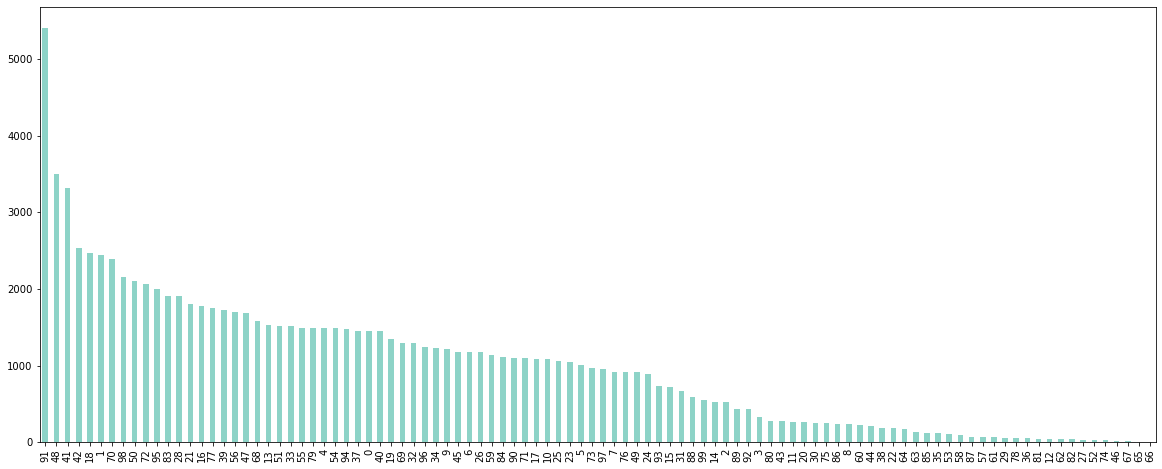

In [8]:
# What are the most frequent hotel clusters in a country?
country_id = 50
fig, (axis1) = plt.subplots(1,1,figsize=(15,10))
country_clusters = df[df["hotel_country"] == country_id]["hotel_cluster"]
country_clusters.value_counts().plot(kind='bar',colormap="Set3",figsize=(20,8))


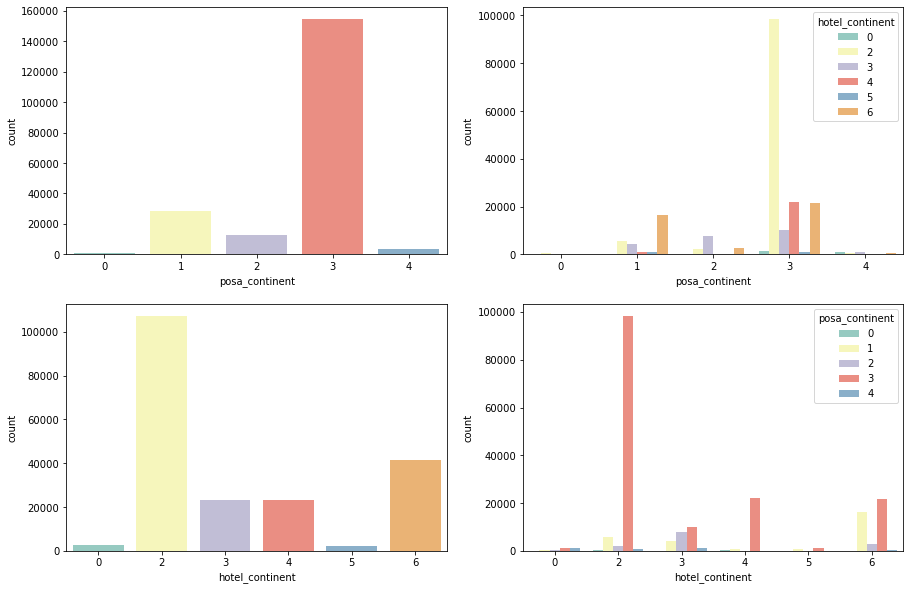

In [9]:
# Plot post_continent & hotel_continent
fig, ((axis1,axis2),(axis3,axis4)) = plt.subplots(2,2,figsize=(15,10))
# Plot frequency for each posa_continent
sns.countplot('posa_continent', data=df,order=[0,1,2,3,4],palette="Set3",ax=axis1)
# Plot frequency for each posa_continent decomposed by hotel_continent
sns.countplot('posa_continent', hue='hotel_continent',data=df,order=[0,1,2,3,4],palette="Set3",ax=axis2)
# Plot frequency for each hotel_continent
sns.countplot('hotel_continent', data=df,order=[0,2,3,4,5,6],palette="Set3",ax=axis3)
# Plot frequency for each hotel_continent decomposed by posa_continent
sns.countplot('hotel_continent', hue='posa_continent', data=df, order=[0,2,3,4,5,6],palette="Set3",ax=axis4)

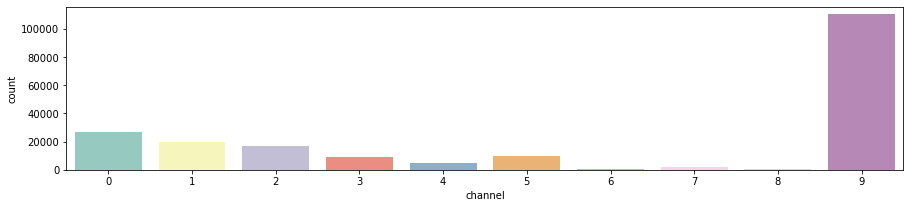

In [10]:
# What's the most impactful channel?
fig, (axis1) = plt.subplots(1,1,figsize=(15,3))
sns.countplot(x='channel', order=list(range(0,10)), data=df, palette="Set3")

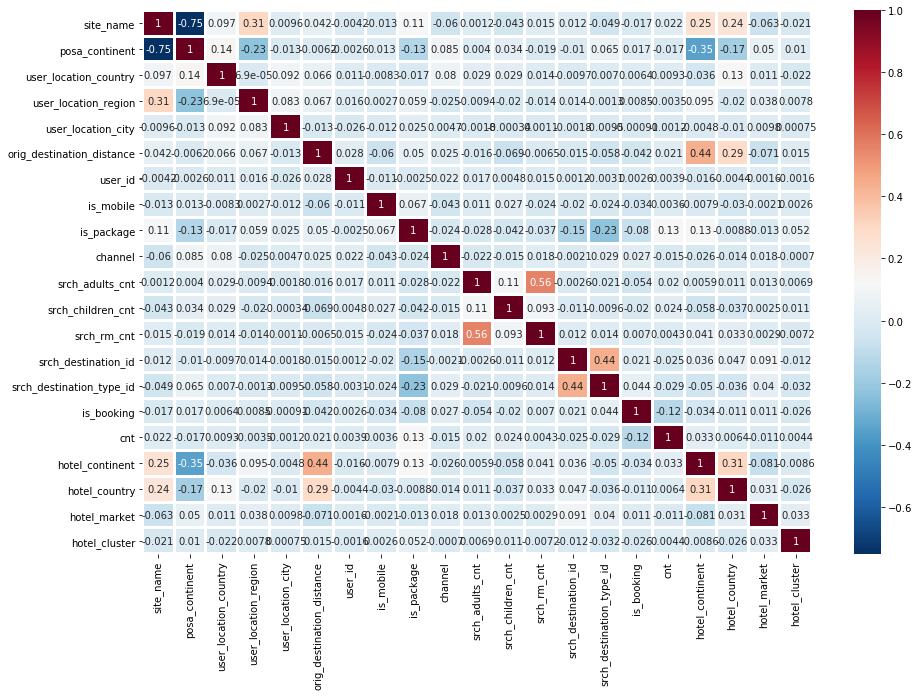

In [11]:
#HeatMap
fig,ax=plt.subplots()
fig.set_size_inches(15,10)
sns.heatmap(df.corr(),cmap='RdBu_r',ax=ax,annot=True,linewidths=2)

In [12]:
# # Step 1
# train = pd.read_csv('Data/train.csv',
#                     dtype={'is_booking':bool,'srch_destination_id':np.int32, 'hotel_cluster':np.int32},
#                     usecols=['srch_destination_id','is_booking','hotel_cluster'],
#                     chunksize=10000)
# aggs = []
# # print('-'*38)
# for chunk in train:
#     agg = chunk.groupby(['srch_destination_id',
#                          'hotel_cluster'])['is_booking'].agg(['sum','count'])
#     agg.reset_index(inplace=True)
#     aggs.append(agg)
#     print('.',end='')
# print('')
# aggs = pd.concat(aggs, axis=0)
# aggs.head()

# EDA
The objective is to predict which hotel_cluster a user will book given the information in his (or her) search. There are 100 clusters in total. In another word, we are dealing with a 100 class classification problem

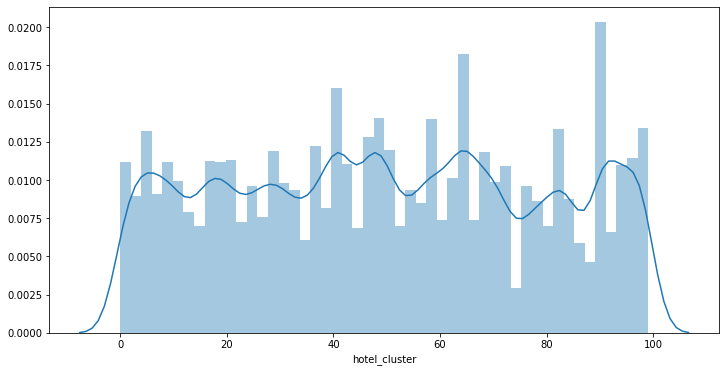

In [13]:
plt.figure(figsize=(12, 6))
sns.distplot(df['hotel_cluster'])

# Preliminary Analysis
After creating new features and removing the features that are not useful, we want to know if anything correlates well with hotel_cluster .This will tell us if we should pay more attention to any particular features.

In [14]:
df.corr()["hotel_cluster"].sort_values()

srch_destination_type_id    -0.032499
hotel_country               -0.026249
is_booking                  -0.025508
user_location_country       -0.021985
site_name                   -0.021176
srch_destination_id         -0.012463
hotel_continent             -0.008577
srch_rm_cnt                 -0.007157
user_id                     -0.001612
channel                     -0.000704
user_location_city           0.000748
is_mobile                    0.002614
cnt                          0.004449
srch_adults_cnt              0.006857
user_location_region         0.007767
posa_continent               0.009969
srch_children_cnt            0.011379
orig_destination_distance    0.014512
hotel_market                 0.032663
is_package                   0.051971
hotel_cluster                1.000000
Name: hotel_cluster, dtype: float64

No column correlates linearly with hotel_cluster, this means that methods which model linear relationship between features might not be suitable for the problem.

# Feature Engineering
1. Check the number of duration of stay
2. NUmber of days betwwn the booking and check-in-days
3. check-in Month and check out years

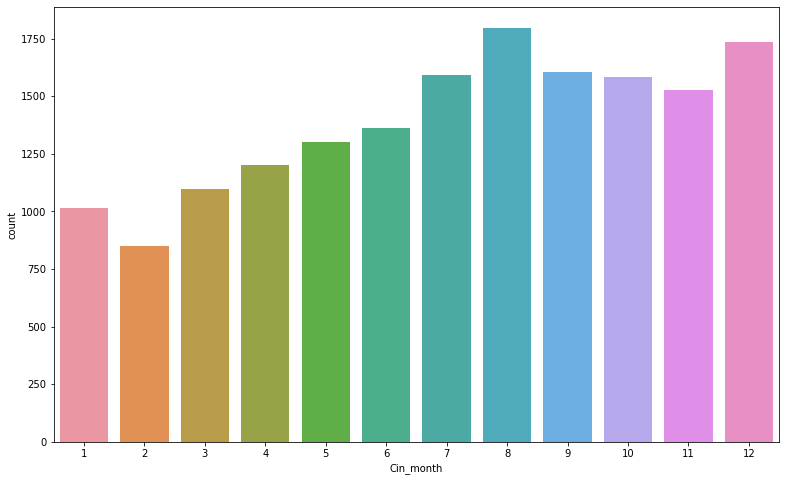

In [15]:
# Function to convert date object into relavant attributes
def convert_date_into_days(df):
    df['srch_ci']= pd.to_datetime(df['srch_ci'])
    df['srch_co']= pd.to_datetime(df['srch_co'])
    df['date_time'] = pd.to_datetime(df['date_time'])
    
    df['stay_dur']= (df['srch_co'] -  df['srch_ci']).astype('timedelta64[D]')

    df['no_of_days_bet_booking'] = (df['srch_co'] - df['date_time']).astype('timedelta64[D]')
    
#for hotel check-in
#Month,Years,Days
    df['Cin_day'] = df['srch_ci'].apply(lambda x:x.day)
    df['Cin_month']=df['srch_ci'].apply(lambda x:x.month)
    df['Cin_year'] = df["srch_ci"].apply(lambda x: x.year)
convert_date_into_days(df)
convert_date_into_days(test_df)

# Count the bookings in each month
fig, ax = plt.subplots()
fig.set_size_inches(13, 8)
sns.countplot('Cin_month',data=df[df["is_booking"] == 1],order=list(range(1,13)),ax=ax)

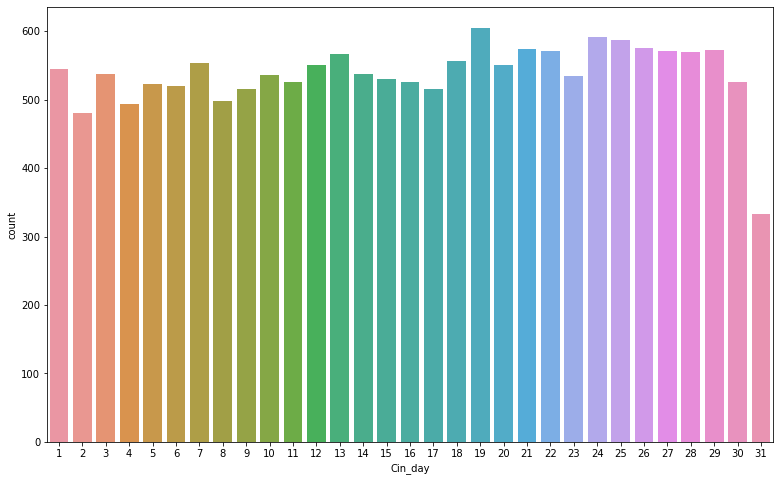

In [16]:
# Count the bookings as per the day
fig, ax = plt.subplots()
fig.set_size_inches(13, 8)
sns.countplot('Cin_day',data=df[df["is_booking"] == 1],order=list(range(1,32)),ax=ax)

In [17]:
bookings_df = df[df["is_booking"]==1]
bookings_df.shape

(16669, 29)

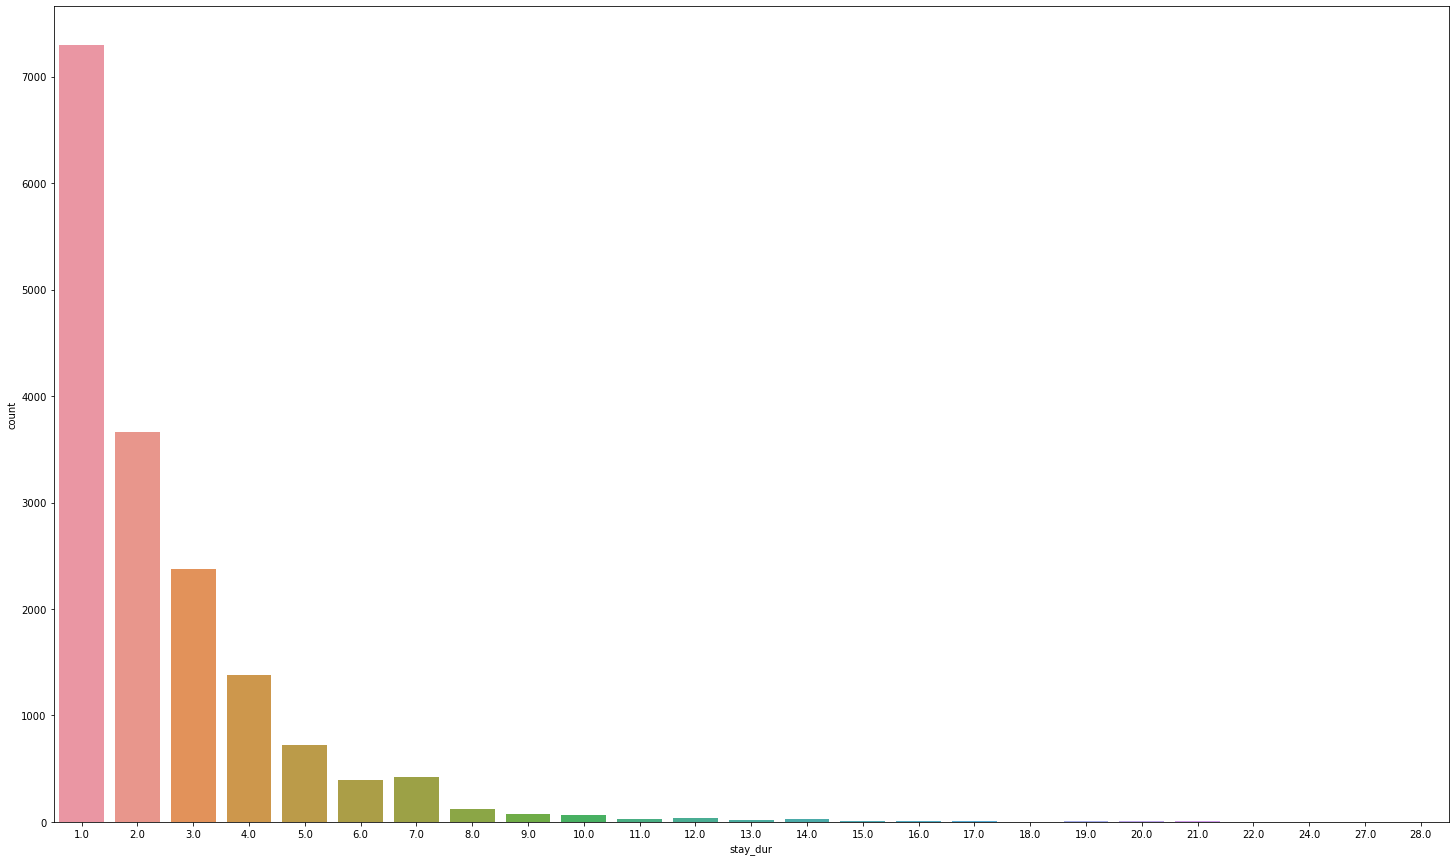

In [18]:
# Count the bookings as per the stay_duration
fig, ax = plt.subplots()
fig.set_size_inches(25, 15)
sns.countplot('stay_dur',data=df[df["is_booking"] == 1],ax=ax)

In [19]:
# drop unnecessary columns, these columns won't be useful in analysis and prediction
test_user_id = test_df['user_id']
columns = ['date_time', 'srch_ci','user_id','srch_destination_type_id','srch_destination_id', 'site_name', 'user_location_region', 'user_location_city', 
                              'user_id', 'srch_co', 'srch_adults_cnt', 'srch_children_cnt', 'srch_rm_cnt']
df.drop(columns=columns,axis=1,inplace=True)
test_df.drop(columns=columns,axis=1,inplace=True)

In [20]:
# Check the percentage of Nan in dataset
total = df.isnull().sum().sort_values(ascending=False)
percent = (df.isnull().sum()/df['hotel_cluster'].count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data

,Total,Percent
orig_destination_distance,69637,0.348185
Cin_year,177,0.000885
Cin_day,177,0.000885
no_of_days_bet_booking,177,0.000885
stay_dur,177,0.000885
Cin_month,177,0.000885
channel,0,0.000000
user_location_country,0,0.000000
is_mobile,0,0.000000
is_package,0,0.000000


In [21]:
# Fill nan with the day which has max occurence
df['Cin_day'] = df['Cin_day'].fillna(26.0)
df['Cin_month'] = df['Cin_month'].fillna(8.0)
df['Cin_year'] = df['Cin_year'].fillna(2014.0)
df['stay_dur'] = df['stay_dur'].fillna(1.0)
df['no_of_days_bet_booking'] = df['no_of_days_bet_booking'].fillna(0.0)

# Fill average values in place for nan, fill with mean
df['orig_destination_distance'].fillna(df['orig_destination_distance'].mean(), inplace=True)

# Simple Predication and Submission

A simple solution implemented with pandas to use the "most popular local hotel" as recommendation.

# Step 1
we count the number of rows and number of booking for every destination-hotel cluster combination.
# Step 2
Computer the number of clicks by subtracting the number of booking form total row counts. computer the "relevance" of a hotel clutser with a weighted sum of bookings and clicks.
# Step 3
Read in the test data and mereg most popular hotel clusters.
   

In [22]:
# train = pd.read_csv('Data/train.csv',
#                     dtype={'is_booking':bool,'srch_destination_id':np.int32, 'hotel_cluster':np.int32},
#                     usecols=['srch_destination_id','is_booking','hotel_cluster'],
#                     chunksize=1000000)
# aggs = []
# print('-'*38)
# for chunk in train:
#     agg = chunk.groupby(['srch_destination_id',
#                          'hotel_cluster'])['is_booking'].agg(['sum','count'])
#     agg.reset_index(inplace=True)
#     aggs.append(agg)
#     print('.',end='')
# print('')
# aggs = pd.concat(aggs, axis=0)
# aggs.head()

Using Chi-Square Statistic in Research
The Chi Square statistic is commonly used for testing relationships between categorical variables.  The null hypothesis of the Chi-Square test is that no relationship exists on the categorical variables in the population; they are independent

CLICK_WEIGHT = 0.05

In [23]:
# # Step 2
# CLICK_WEIGHT = 0.05
# agg = aggs.groupby(['srch_destination_id','hotel_cluster']).sum().reset_index()
# agg['count'] -= agg['sum']
# agg = agg.rename(columns={'sum':'bookings','count':'clicks'})
# agg['relevance'] = agg['bookings'] + CLICK_WEIGHT * agg['clicks']
# agg.head()

# # Define a function to get most popular hotels for a destination group.
# def most_popular(group, n_max=6):
#     relevance = group['relevance'].values
#     hotel_cluster = group['hotel_cluster'].values
#     most_popular = hotel_cluster[np.argsort(relevance)[::-1]][:n_max]
#     return np.array_str(most_popular)[1:-1] # remove square brackets

# # Get most popular hotel clusters for all destinations.
# most_pop = agg.groupby(['srch_destination_id']).apply(most_popular)
# most_pop = pd.DataFrame(most_pop).rename(columns={0:'hotel_cluster'})
# most_pop.head()
# # Step 3: Read in the test data and merge most popular hotel clusters.
# test = pd.read_csv('Data/test.csv',
#                     dtype={'srch_destination_id':np.int32},
#                     usecols=['srch_destination_id'],)
# test = test.merge(most_pop, how='left',left_on='srch_destination_id',right_index=True)
# test.head()

# # Check hotel_cluster column in test for null values
# test.hotel_cluster.isnull().sum()

# # Let's fill nas with hotel clusters that are most popular overall.
# most_pop_all = agg.groupby('hotel_cluster')['relevance'].sum().nlargest(5).index
# most_pop_all = np.array_str(most_pop_all)[1:-1]
# print(most_pop_all)

# test.hotel_cluster.fillna(most_pop_all,inplace=True)

# test.hotel_cluster.to_csv('submission.csv',header=True, index_label='id')

# summ=pd.read_csv('submission.csv')
# summ.head(25)
# summ.shape

# Implementing Algorithms 
We are only intrested in booking events 

In [24]:
df = pd.read_csv("Data/train.csv",nrows=200000)

In [25]:
df= df.loc[df['is_booking']==1]


Get features and labels.

In [28]:
X= df.drop(['user_id','hotel_cluster','is_booking'],axis=1)
Y=df.hotel_cluster

In [31]:
from datetime import datetime
def get_year(x):
    if x is not None and type(x) is not float:
        try:
            return datetime.strptime(x, '%Y-%m-%d').year
        except ValueError:
            return datetime.strptime(x, '%Y-%m-%d %H:%M:%S').year
    else:
        return 2013
    pass
def get_month(x):
    if x is not None and type(x) is not float:
        try:
            return datetime.strptime(x, '%Y-%m-%d').month
        except:
            return datetime.strptime(x, '%Y-%m-%d %H:%M:%S').month
    else:
        return 1
    pass
    
def left_merge_dataset(left_dframe, right_dframe, merge_column):
    return pd.merge(left_dframe, right_dframe, on=merge_column, how='left')

In [32]:
df['date_time_year'] = pd.Series(df.date_time, index = df.index)
df['date_time_month'] = pd.Series(df.date_time, index = df.index)
from datetime import datetime
df.date_time_year = df.date_time_year.apply(lambda x: get_year(x))
df.date_time_month = df.date_time_month.apply(lambda x: get_month(x))
del df['date_time']

In [33]:
df['srch_ci_year'] = pd.Series(df.srch_ci, index=df.index)
df['srch_ci_month'] = pd.Series(df.srch_ci, index=df.index)
# convert year & months to int
df.srch_ci_year = df.srch_ci_year.apply(lambda x: get_year(x))
df.srch_ci_month = df.srch_ci_month.apply(lambda x: get_month(x))
# remove the srch_ci column
del df['srch_ci']

In [34]:
df['srch_co_year'] = pd.Series(df.srch_co, index=df.index)
df['srch_co_month'] = pd.Series(df.srch_co, index=df.index)
# convert year & months to int
df.srch_co_year = df.srch_co_year.apply(lambda x: get_year(x))
df.srch_co_month = df.srch_co_month.apply(lambda x: get_month(x))
# remove the srch_co column
del df['srch_co']

In [37]:
pieces = [df.groupby(['srch_destination_id','hotel_country','hotel_market','hotel_cluster'])['is_booking'].agg(['sum','count'])]
agg = pd.concat(pieces).groupby(level=[0,1,2,3]).sum()
agg.dropna(inplace=True)
agg.head()

sum  count
srch_destination_id hotel_country hotel_market hotel_cluster            
8                   50            416          32               1      1
                                               48               1      1
                                               77               1      1
11                  50            824          94               1      1
14                  27            1434         20               1      1

In [39]:
agg['sum_and_cnt'] = 0.85*agg['sum'] + 0.15*agg['count']
agg = agg.groupby(level=[0,1,2]).apply(lambda x: x.astype(float)/x.sum())
agg.reset_index(inplace=True)
agg.head()

,srch_destination_id,hotel_country,hotel_market,hotel_cluster,sum,count,sum_and_cnt
0,8,50,416,32,0.333333,0.333333,0.333333
1,8,50,416,48,0.333333,0.333333,0.333333
2,8,50,416,77,0.333333,0.333333,0.333333
3,11,50,824,94,1.000000,1.000000,1.000000
4,14,27,1434,20,1.000000,1.000000,1.000000


In [40]:
agg_pivot = agg.pivot_table(index=['srch_destination_id','hotel_country','hotel_market'], columns='hotel_cluster', values='sum_and_cnt').reset_index()
agg_pivot.head()

hotel_cluster,srch_destination_id,hotel_country,hotel_market,0,1,2,3,4,5,6,...,90,91,92,93,94,95,96,97,98,99
0,8,50,416,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,11,50,824,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
2,14,27,1434,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,16,50,419,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,19,102,1522,NaN,NaN,NaN,NaN,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [41]:
df = pd.merge(df, dest, how='left', on='srch_destination_id')
df = pd.merge(df, agg_pivot, how='left', on=['srch_destination_id','hotel_country','hotel_market'])
df.fillna(0, inplace=True)
df.shape

(16669, 276)

In [42]:
df = df.loc[df['is_booking'] == 1]

In [43]:
X = df.drop(['user_id', 'hotel_cluster', 'is_booking'], axis=1)
y = df.hotel_cluster

# Naive Bayes 

In [44]:
from sklearn.naive_bayes import GaussianNB

clf= make_pipeline(preprocessing.StandardScaler(),
                  GaussianNB(priors=None))
np.mean(cross_val_score(clf,X,Y,cv=10))

0.07678899994310862